In [1]:
# Basic Imports
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from functools import partial
from tqdm import tqdm

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
# import torch.utils.data as data
# from torch.utils.data import DataLoader, Dataset
# from torchvision.datasets import MNIST
import torch
import torch.nn as tnn

# Flax training loop
from flax import jax_utils
from jax.scipy.stats import beta

# JAX/Flax
import jax
from jax import jit
import jax.numpy as jnp
from jax import random
from jax.scipy.stats import beta
import flax
from flax import jax_utils
from flax import linen as nn
import optax
import orbax.checkpoint
from flax.training import train_state, orbax_utils
import wandb

## Create a dataset of 2 Gaussians

$p_{data} = 0.5 \mathcal{N}(\mu_1, \sigma I) + 0.5 \mathcal{N}(-\mu_1, \sigma I)$

In [2]:
key = random.PRNGKey(0)
rng, subkey1, subkey2 = random.split(key, num=3)

(2000, 2)


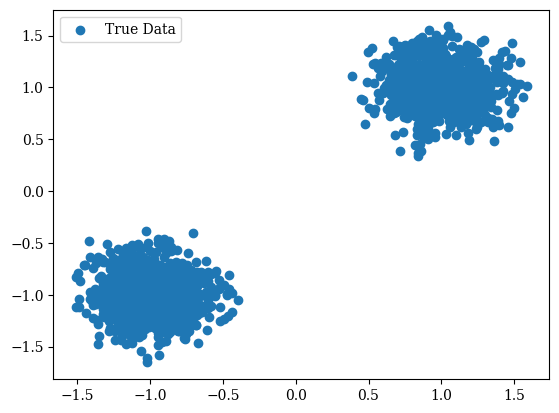

In [3]:
size = 1000 # N
std = 0.2
mean_scale = 1

# Generate data for X_0 & X_1
X_0 = mean_scale + random.normal(subkey1, shape=(size, 2)) * std
X_1 = -mean_scale + random.normal(subkey2, shape=(size, 2)) * std

# Concantenate
X = jnp.concatenate([X_0, X_1], axis=0)
print(X.shape)

# Visuaize
plt.scatter(X[:, 0], X[:, 1], label='True Data')
plt.legend()
plt.show()

## Construct data loader

In [4]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return np.array(self.X[idx])

def numpy_collate(batch):
    """
    Function to allow jnp.arrays to be used in PyTorch Dataloaders.
    """
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
    
class NumpyLoader(torch.utils.data.DataLoader):
    """
    Custom PyTorch DataLoader for numpy/JAX arrays
    """
    def __init__(self, dataset, batch_size=1,
                 shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0,
                 pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             sampler=sampler,
                                             batch_sampler=batch_sampler,
                                             num_workers=num_workers,
                                             collate_fn=numpy_collate,
                                             pin_memory=pin_memory,
                                             drop_last=drop_last,
                                             timeout=timeout,
                                             worker_init_fn=worker_init_fn)
    
train_dataset = JaxDataset(X=X)
train_loader = NumpyLoader(dataset=train_dataset, batch_size=512, shuffle=False)

In [5]:
batch = next(iter(train_loader))
print(batch.shape)

(512, 2)


## Construct NN

$$\text{P}(k, 2i) = \text{sin}\Big(\frac{k}{n^{2i/d}} \Big)$$
$$\text{P}(k, 2i+1) = \text{cos}\Big(\frac{k}{n^{2i/d}} \Big)$$

See [this](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/#:~:text=What%20Is%20Positional%20Encoding%3F,item's%20position%20in%20transformer%20models.) article about positional encoding.

In [6]:
def getPositionEncoding(t: jnp.array, d: int, n: int = 10000) -> np.ndarray:
    seq_len = len(t)

    # Calculate the denominator for all dimensions
    denominator = n ** (2.0 * (jnp.arange(d) // 2) / d)

    # Calculate the encoding for all positions and dimensions
    t = t[:, None]  # make it a column vector
    t_scaled = t / denominator  # this will broadcast t along the columns

    # Generate positional encodings
    P = jnp.zeros((seq_len, d))
    sin_component = jnp.sin(t_scaled[:, :d//2])
    cos_component = jnp.cos(t_scaled[:, :d//2])
    
    P = P.at[:, 0::2].set(sin_component)
    P = P.at[:, 1::2].set(cos_component)

    return P

In [7]:
class ScoreNet(nn.Module):
    """
    Common architecture for score-based generative models,
    """
    dim: int = 10  # Change from 2 to 10 to match input size
    latent_dim: int = 32
    std_data: float = 0.5
    
    @nn.compact
    def __call__(self, x, t):
        # Preconditioning terms in the "EDM" model
        t = t.squeeze()  # Ensure t is scalar if it's not
        c_out = t * self.std_data / jnp.sqrt(self.std_data**2 + t**2)
        c_skip = self.std_data**2 / (self.std_data**2 + t**2)

        t = jnp.log(t.flatten()) / 4.
        
        # Basic Network architecture
        x_1 = nn.Dense(self.latent_dim)(x) + getPositionEncoding(t, d=self.latent_dim)
        x_2 = nn.relu(x_1)
        x_3 = nn.relu(nn.Dense(self.latent_dim)(x_2) + nn.Dense(self.latent_dim)(x_1))
        x_4 = nn.relu(nn.Dense(self.latent_dim)(x_3)) + nn.Dense(self.latent_dim)(x)
        x_5 = nn.Dense(self.dim)(x_4) 
        
        # Reshape c_out and c_skip to match dimensions for broadcasting
        c_out = jnp.reshape(c_out, (-1, 1))
        c_skip = jnp.reshape(c_skip, (-1, 1))
        
        return c_out * x_5 + c_skip * x

model = ScoreNet(dim=2, latent_dim=32, std_data=0.5) 

rnd_normal = random.normal(subkey1, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)
print(t.shape)
print(model.tabulate(jax.random.PRNGKey(9), batch, t))

(512, 1)

                                ScoreNet Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs           ┃ outputs         ┃ params             ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│         │ ScoreNet │ - float32[512,2] │ float32[512,2]  │                    │
│         │          │ - float32[512,1] │                 │                    │
├─────────┼──────────┼──────────────────┼─────────────────┼────────────────────┤
│ Dense_0 │ Dense    │ float32[512,2]   │ float32[512,32] │ bias: float32[32]  │
│         │          │                  │                 │ kernel:            │
│         │          │                  │                 │ float32[2,32]      │
│         │          │                  │                 │                    │
│         │          │                  │                 │ 96 (384 B)         │
├─────────┼───────

## Training Loop

**Algorithm 2:** PFGM++ training with hyperparameter transferred from EDM

**Input:**

- $\sigma(t)$ = `t`
- $r = \sigma\sqrt{D}$
- Noise distribution: $\text{ln}(\sigma) \sim \mathcal{N}(P_{mean}, P_{std}^2) = \mathcal{N}(-1.2, 1.2^2) \rightarrow \sigma \sim \text{exp}(\mathcal{N}(-1.2, 1.2^2))$
- Loss weighting: $\lambda(\sigma) = \frac{(\sigma^2 + \sigma^2_{data})}{(\sigma \cdot \sigma_{data})^2} = \frac{(t^2 + \sigma^2_{data})}{(t \cdot \sigma_{data})^2}$
$$f_\theta(\mathbf{x}, \sigma) = \frac{c_{skip}(\sigma)\mathbf{x} + c_{out}(\sigma)F_\theta\big(c_{in}(\sigma)\mathbf{x}, c_{noise}(\sigma)\big) - x}{\sigma} \approx \sigma \nabla_x \text{log}p_\sigma(x)$$

- $$f_\theta(\tilde{\mathbf{x}}) = \frac{c_{skip}(r/\sqrt{D})\mathbf{x} + c_{out}(r/\sqrt{D})F_\theta\big(c_{in}(r/\sqrt{D})\mathbf{x}, c_{noise}(r/\sqrt{D})\big) - x}{r/\sqrt{D}} \approx \sqrt{D} \frac{E(\tilde{\mathbf{x}})_x}{E(\tilde{\mathbf{x}})_r}$$

    - $F_\theta$ = NN 
    - $c_{in}(\sigma) = \frac{1}{\sqrt{\sigma^2 + \sigma^2_{data}}}$
    - $c_{out}(\sigma) = \frac{\sigma \cdot \sigma_{data}}{\sqrt{\sigma^2 + \sigma^2_{data}}}$
    - $c_{skip}(\sigma) = \frac{\sigma_{data}^2}{\sigma^2 + \sigma^2_{data}}$
    - $c_{in}(\sigma) = \frac{1}{4}\text{ln}(\sigma)$ 
    - $\sigma_{data} = 0.5$
- $$ r_i = \big(r_{max}^{1/\rho} + \frac{i}{N-1}(r_{min}^{1/\rho} - r_{max}^{1/\rho})\big)^\rho \hspace{0.2in} \text{ where } \hspace{0.2in} r_N = 0$$
    
    
    
**Pseudocode:**

1. Sample a batch of data $\{\mathbf{y}_i\}^\mathcal{B}_{i=1}$ from $p(\mathbf{y})$
2. Sample standard deviations $\{\sigma_i \}^\mathcal{B}_{i=1}$ from $p(\sigma)$
3. Sample $r$ from $p_r$: $\{r_i = \sigma_i(R)\}^\mathcal{B}_{i=1}$
4. Samples radiuses $\{R_i \sim p_{r_i}(R) \}^\mathcal{B}_{i=1}$
5. Sample uniform angles $\{\mathbf{v}_i = \frac{\mathbf{u}_i}{|| \mathbf{u}_i ||_2} \}^\mathcal{B}_{i=1}$, with $\mathbf{u}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
6. Get perturbed data $\{\hat{\mathbf{y}}_i = \mathbf{y}_i + R_i \mathbf{v}_i \}^\mathcal{B}_{i=1}$
7. Calculate loss $\ell(\theta) = \sum^\mathcal{B}_{i=1} \lambda(\sigma_i)||f_\theta(\hat{\mathbf{y}}_i, \sigma_i) - \mathbf{y}_i||_2^2$
8. Update the network parameter $\theta$ via Adam optimizer


In [8]:
# Create TrainState
def init_train_state(model: Any,
                     random_key: Any,
                     x_shape: tuple,
                     t_shape: tuple,
                     learning_rate: int) -> train_state.TrainState:
    """
    Function to initialize the TrainState dataclass, whcih represents
    the entire training state, including step number, parameteers, and 
    optimizer state. Used in a Flax framework because you no longer need
    to initialize the model again & again with new variables. Rather we 
    just update the "state" of the model and pass this as inputs to functions.
    
    Args:
    -----
        model: nn.Module
            Model we want to train.
        random_key: jax.random.PRNGKey()
            Used to trigger the initialization functions, which generate
            the initial set of parameters that the model will use.
        x_shape: tuple
            Shape of the batch of data (x) that will be input into the model.
            Used to trigger shape inference.
        t_shape: tuple
            Shape of the batch of data (t) that will be input into the model.
            Used to trigger shape inference.
        learning_rate: float
            How large of a step the optimizer should take.
            
    Returns:
    --------
        train_state.TrainState:
            A utility class for handling parameter and gradient updates.
    """
    # Initialize the model
    variables = model.init(random_key, jnp.ones(x_shape), jnp.ones(t_shape))
    
    # Create the optimizer
    optimizer = optax.adam(learning_rate)
    
    # Create a state
    return flax.training.train_state.TrainState.create(apply_fn=model.apply,
                                                       tx=optimizer,
                                                       params=variables['params'])

def sample_norm(N, D, size, key):
    """
    Sample noise from perturbation kernel p_r.
    Sampling from inverse-beta distribution found in Appendix B.
    """
    R1 = random.beta(a=N / 2., b=D / 2., key=key, shape=(size,))
    R2 = R1 / (1 - R1 +1e-8)
    return R2

def train_step(state, batch, std_data, D, N):
    """
    Args:
    ----
        D: int
            The extra dimensions (D>1)
        N: int
            The dimensionality of the data
    """
    # Define the loss function
    def loss_fn(params):
        key = random.PRNGKey(0)
        
        # Sampling from the noise distribution (Table 1 Karras et al. 2022)
        rnd_normal = random.normal(key, shape=(batch.shape[0], 1))
        t = jnp.exp(rnd_normal * 1.2 - 1.2)
        # Phase alignment of Diffusion Models -> PFGM++ (Appendix C)
        # Note: t = sigma in the "EDM" design choice (Karras et al. 2022)
        r = t * jnp.sqrt(D)
        
        # Sampling from p_r(R) by change-of-variable (Appendix B)
        R2 = sample_norm(N, D, batch.shape[0], key)
        R3 = (r.squeeze() * jnp.sqrt(R2 +1e-8)).reshape(len(R2), -1)
        
        # Sampling the uniform angle component
        unit_gaussian = random.normal(key, shape=(batch.shape[0], N))
        unit_gaussian = unit_gaussian / jnp.linalg.norm(unit_gaussian, ord=2, axis=1, keepdims=True)
        x_hat = batch + (unit_gaussian * R3)
        
        # Preconditions (Table 1 & Sect. 5 of Karras et al. 2022)
        c_in = 1 / jnp.sqrt(std_data**2 + t**2)
        c_out = t * std_data / jnp.sqrt(std_data**2 + t**2)
        c_skip = std_data**2 / (std_data**2 + t**2)

        # f_theta in Karras et al. 2022
        D_x = state.apply_fn({'params': params}, x_hat * c_in, t)
        
        # lambda(theta) in Karras et al. 2022 
        # using the loss weighting of "EDM"
        weight = (t**2 + std_data ** 2) / (t*std_data) ** 2
        # Calculate weighted loss
        loss = jnp.sum(weight * ((D_x - batch) ** 2), axis=1).mean()
        return loss
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss

def accumulate_metrics(metrics):
    """
    Function that accumulates all the per batch metrics into
    per epoch metrics
    """
    metrics = jax.device_get(metrics)
    return {
        k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]
    }

def save_checkpoint(ckpt_dir: str,
                    state: Any,
                    step: int,
                    run_name: str) -> None:
    """
    Save the training state as a checkpoint
    
    Args:
    -----
        ckpt_dir: str
            Directory to save the checkpoint files.
        state: Any
            The training state to be saved.
        step: int
            Current training step or epoch number.
        run_name: str
            Name to associate with checkpoint on wandb
    """
    ckptr = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())
    
    # Ensure directory exists
    os.makedirs(ckpt_dir, exist_ok=True)
    
    # Create checkpoint file path with the ".flax" extension
    ckpt_file = os.path.join(ckpt_dir, f"checkpoint_{step}.flax")
    
    # Save checkpoint to local directory
    ckptr.save(ckpt_file, state,
               save_args=flax.training.orbax_utils.save_args_from_target(state),
               force=True)

In [14]:
# Instantiate basic wandb logger params
wandb.init(project='toy_pfgmpp',
           job_type='simple_noise_net',
           dir= 'saved_models/toy')

config = wandb.config
config.seed = 21
config.batch_size = 512
config.learning_rate = 1e-3
config.epochs = 300
config.dim = 2
config.latent_dim = 32
config.std_data = 0.5
config.D = 300
config.N = 2

# Get the rng & model instantiated
init_rng = random.PRNGKey(config.seed)
model = ScoreNet(dim=config.dim,
                 latent_dim=config.latent_dim,
                 std_data=config.std_data)  # Change dim to 10

# Sample the noise distribution
rnd_normal = random.normal(subkey1, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)  

# Initialize the models state
state = init_train_state(model=model,
                               random_key=init_rng,
                               x_shape=batch.shape,
                               t_shape=t.shape,
                               learning_rate=config.learning_rate)

# Train the model
for epoch in tqdm(range(config.epochs)):
# for epoch in range(config.epochs):
    rng, input_rng = jax.random.split(rng)
    # Initialize a list to store all batch-level metrics
    batch_metrics = []
    for batch in train_loader:
        # Prepare the data
        batch = jax.device_put(batch)

        # Update the model
        train_step_jit = jax.jit(train_step, static_argnums=(3,4))
        state, batch_loss = train_step_jit(state, batch, config.std_data, config.D, config.N)    
    
        # Store the batch-level metric in the list
        batch_metrics.append({'Train Loss': batch_loss})
    
    # Use accumulate_metrics to calculate average metrics for the epoch
    epoch_metrics = accumulate_metrics(batch_metrics)


    # Log average metrics for the epoch to wandb
    wandb.log(epoch_metrics)
    
# Save checkpoint
checkpt_dir = 'saved_models/toy' # dir to save the checkpoints
save_checkpoint(checkpt_dir, state, config.epochs, 'toy_pfgmpp')

# Save model checkpoint to wandb
wandb.save(os.path.join(checkpt_dir, f"checkpoint_{config.epochs}.flax"))

Train Loss,█▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,17.91175


100%|█████████████████████████████████████████| 300/300 [06:34<00:00,  1.31s/it]


['saved_models/toy/wandb/run-20230724_063900-and8agcu/files/saved_models/toy/checkpoint_300.flax']

In [21]:
def load_checkpoint(ckpt_dir: str,
                    ckpt_file: str,
                    model: Type[nn.Module]) -> Any:
    """
    Load checkpoint from local directory
    
    Args:
    -----
        ckpt_dir: str
            Local directory where checkpoint file is saved.
        ckpt_file: str
            Name of checkpoint file.
        model: nn.Module
            Model for which the checkpoint is being loaded
        
    Returns:
    -------
        Any: Model with trained checkpoint parameters
    """
    # Check if checkpoint file exists in locoal directory
    if not os.path.exists(os.path.join(ckpt_dir, ckpt_file)):
        raise FileNotFoundError(f"No checkpoints file found at {os.path.join(ckpt_dir, ckpt_file)}")
        

    # Create a Checkpointer using the PyTreeCheckpointHandler
    ckptr = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())
    
    # Restore state dictionary from the checkpoint path
    state_dict = ckptr.restore(ckpt_dir, item=None)
    
    # Update model parameters using restored state dict
    params = {'params': state_dict['params']}
    return model.bind(params)

In [22]:
# Get the rng & model instantiated
init_rng = random.PRNGKey(config.seed)
model = ScoreNet(dim=config.dim,
                 latent_dim=config.latent_dim,
                 std_data=config.std_data)  

batch = next(iter(train_loader))

updated_model = load_checkpoint(ckpt_dir='saved_models/toy/checkpoint_300.flax',
                                ckpt_file='checkpoint',
                                model=model)

In [32]:
rnd_normal = random.normal(subkey1, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2) 

params = model.init(subkey1, batch, t) # Initialization call

# print(updated_model(batch, t))
# print()
# print(model.apply(params, batch, t))

# Sampling Loop

**Algorithm 4:** PFGM++ sampling with hyperparameter transferred from EDM

**Input:**

- $\sigma(t)$ = `t`
- $r = \sigma\sqrt{D}$
- Noise distribution: $\text{ln}(\sigma) \sim \mathcal{N}(P_{mean}, P_{std}^2) = \mathcal{N}(-1.2, 1.2^2) \rightarrow \sigma \sim \text{exp}(\mathcal{N}(-1.2, 1.2^2))$
- Loss weighting: $\lambda(\sigma) = \frac{(\sigma^2 + \sigma^2_{data})}{(\sigma \cdot \sigma_{data})^2} = \frac{(t^2 + \sigma^2_{data})}{(t \cdot \sigma_{data})^2}$
$$f_\theta(\mathbf{x}, \sigma) = \frac{c_{skip}(\sigma)\mathbf{x} + c_{out}(\sigma)F_\theta\big(c_{in}(\sigma)\mathbf{x}, c_{noise}(\sigma)\big) - x}{\sigma} \approx \sigma \nabla_x \text{log}p_\sigma(x)$$

- $$f_\theta(\tilde{\mathbf{x}}) = \frac{c_{skip}(r/\sqrt{D})\mathbf{x} + c_{out}(r/\sqrt{D})F_\theta\big(c_{in}(r/\sqrt{D})\mathbf{x}, c_{noise}(r/\sqrt{D})\big) - x}{r/\sqrt{D}} \approx \sqrt{D} \frac{E(\tilde{\mathbf{x}})_x}{E(\tilde{\mathbf{x}})_r}$$

    - $F_\theta$ = NN 
    - $c_{in}(\sigma) = \frac{1}{\sqrt{\sigma^2 + \sigma^2_{data}}}$
    - $c_{out}(\sigma) = \frac{\sigma \cdot \sigma_{data}}{\sqrt{\sigma^2 + \sigma^2_{data}}}$
    - $c_{skip}(\sigma) = \frac{\sigma_{data}^2}{\sigma^2 + \sigma^2_{data}}$
    - $c_{in}(\sigma) = \frac{1}{4}\text{ln}(\sigma)$ 
    - $\sigma_{data} = 0.5$
- $$ r_i = \big(r_{max}^{1/\rho} + \frac{i}{N-1}(r_{min}^{1/\rho} - r_{max}^{1/\rho})\big)^\rho \hspace{0.2in} \text{ where } \hspace{0.2in} r_N = 0$$
    
    
    
**Pseudocode:**

1. Set $r_{max} = \sigma_{max}\sqrt{D}$
2. Sample radius $R \sim p_{r_{max}}(R)$ and uniform angle $\mathbf{v} = \frac{\mathbf{u}}{|| \mathbf{u} ||_2}$
3. Get initial data $\mathbf{x}_0 = R\mathbf{v}$ 
4. $\textbf{for } i = 0, ..., T-1 \textbf{ do}$
    1. $d_i = (\mathbf{x}_i - f_\theta(\mathbf{x}_i, t_i)) / t_i$
    2. $\mathbf{x}_{i+1} = \mathbf{x}_i + (t_{i+1} - t_i)d_i$
    3. $\textbf{if } t_{i+1} > 0 \textbf{ then}$
        1. $d^{'}_{i} = (\mathbf{x}_{i+1} - f_\theta(\mathbf{x}_{i+1}, t_{i+1}))/ t_{i+1}$
        2. $\mathbf{x}_{i+1} = \mathbf{x}_i + (t_{i+1} - t_i)(\frac{1}{2}\mathbf{d}_i + \frac{1}{2}\mathbf{d}^{'})$
    4. $\textbf{end if}$
5. $\textbf{end for}$ 


In [ ]:
min_t = 0.001
num_steps = 50
sample_size = 2000
S_churn = 0
S_min = 0.01
S_max = 5
S_noise = 1.

rho = 7
latents = jax.normal(